In [1]:
import pandas as pd
import numpy as np
from glob import glob
from re import match, sub
from missingno import matrix as mmatrix
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from math import ceil
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from statsmodels.formula.api import ols
from os import listdir

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
if 'figure_dir.txt' in listdir():
    with open('figure_dir.txt', 'r') as f:
        fig_dir = f.readline().strip().replace('\\', '/')
        tbl_dir = f"{fig_dir.rsplit('/', maxsplit=2)[0]}/Tables/"
else:
    fig_dir = 'Figures/'
    tbl_dir = 'Tables/'

def trim_trailing_zeros(number_string):
    '''
    Take a string with numbers and remove any trailing zeros from the number.
    '''
    return sub(
        r'(?:\.0+|(\.\d+)0+)(%?)$', 
        '\\1\\2', number_string
    )

def neaten_ticks(
        ax, axis, tick_range, ticks, dp=0, fmt='f', twin=False
    ):
    '''
    Take a plot ax and convert its x or y axis into a neatened range frame.
    '''
    # Set sets.
    eval(f"ax.set_{axis}ticks")(sorted([*ticks, *tick_range]))
    is_log = eval(f"ax.get_{axis}scale")() == 'log' 
    # Set labels.
    eval(f"ax.set_{axis}ticklabels")([
        f"$\\mathdefault{{10^{{{ex:.0f}}}}}$" 
        if is_log and int((ex := np.log10(e))) == ex 
        else trim_trailing_zeros(eval(f'''f"{{e:.0{dp}{fmt}}}"'''))
        for e in eval(f"ax.get_{axis}ticks")()
    ])
    # Limit axis outline to data range.
    ax.spines[
        'right' if twin else 'bottom' if axis == 'x' else 'left'
    ].set_bounds(*tick_range)

def show(
    fig, axes=[], tight=False, despine=True, despine_twin=False, 
    delax=True, file=None, legend_loc=0, filetype='pdf'
):
    '''Style and show a matplotlib plot.'''
    if tight: plt.tight_layout() # Neaten subplots.
    # Remove unnecessary outlines from plots with twin axes.
    # Note that this method assumes all axes have twins.
    if despine_twin:
        for ax in axes[::2]:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        for ax in axes[1::2]:
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
    # Remove unnecessary outlines.
    elif despine:
        for ax in axes:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    for ax in axes:
    # Remove unused subplots.
        if delax and not ax.has_data(): fig.delaxes(ax)
        ax.tick_params(
            axis='both', which='minor', 
            bottom=False, left=False, right=False
        )
        # Style the legend if a legend is present.
        if ax.get_legend():
            handles, labels = ax.get_legend_handles_labels()
            labels = [e.title() for e in labels]
            legend_title = ax.get_legend().get_title().get_text().title()
            ax.legend(
                handles=handles, labels=labels, 
                title=legend_title, loc=legend_loc
            )
    # Save file if a filename is provided.
    if file:
        plt.savefig(
            f'{fig_dir}/Plots/{file}.{filetype}', dpi = 300,
            bbox_inches = 'tight', pad_inches = 1/25
        )
    plt.show()
    

In [3]:
CSVs = glob('data/*/*.csv')

for csv in CSVs:
    csv = csv.replace('\\', '/')
    file = match(r'data.*/(.*?)\.csv', csv).group(1)
    print(file)
    exec(f'{file} = pd.read_csv("{csv}")')
    exec(f'{file}["state"] = "{file.split('_')[-1].upper()}"')


forecastdemand_qld
forecastdemand_sa
forecastdemand_vic
temprature_qld
temprature_sa
temprature_vic
totaldemand_qld
totaldemand_sa
totaldemand_vic
forecastdemand_nsw
temperature_nsw
totaldemand_nsw


In [4]:
# totaldemand_nsw
# forecastdemand_nsw
temperature_nsw


,LOCATION,DATETIME,TEMPERATURE,state
0,Bankstown,1/1/2010 0:00,23.1,NSW
1,Bankstown,1/1/2010 0:01,23.1,NSW
2,Bankstown,1/1/2010 0:30,22.9,NSW
3,Bankstown,1/1/2010 0:50,22.7,NSW
4,Bankstown,1/1/2010 1:00,22.6,NSW
...,...,...,...,...
220321,Bankstown,17/3/2021 23:00,19.1,NSW
220322,Bankstown,17/3/2021 23:20,19.0,NSW
220323,Bankstown,17/3/2021 23:30,18.8,NSW
220324,Bankstown,17/3/2021 23:34,18.8,NSW


In [5]:
def get_metadata(data, name):
    return {
        'Dataset': name, 
        'Records': len(data), 
        'Variables': len([e for e in data.columns if e != 'state']),
        'Size in memory (MB)': data.drop(columns=['state']).memory_usage(deep=True).sum() / 1e6
    }

metadata = []


In [6]:
dem = pd.concat([totaldemand_qld, totaldemand_sa, totaldemand_vic])

dem.DATETIME = pd.to_datetime(dem.DATETIME, format="%Y-%m-%d %H:%M:%S")
totaldemand_nsw.DATETIME = pd.to_datetime(totaldemand_nsw.DATETIME, format="%d/%m/%Y %H:%M")
dem = pd.concat([dem, totaldemand_nsw]).reset_index(drop=True)
# dem = dem.drop(columns=['REGIONID'])

dem = dem[dem.state == 'NSW'].reset_index(drop=True)

# print(dem.isnull().sum())

metadata.append(get_metadata(dem, 'totaldemand_nsw'))

dem


,DATETIME,TOTALDEMAND,REGIONID,state
0,2010-01-01 00:00:00,8038.00,NSW1,NSW
1,2010-01-01 00:30:00,7809.31,NSW1,NSW
2,2010-01-01 01:00:00,7483.69,NSW1,NSW
3,2010-01-01 01:30:00,7117.23,NSW1,NSW
4,2010-01-01 02:00:00,6812.03,NSW1,NSW
...,...,...,...,...
196508,2021-03-17 22:00:00,7419.77,NSW1,NSW
196509,2021-03-17 22:30:00,7417.91,NSW1,NSW
196510,2021-03-17 23:00:00,7287.32,NSW1,NSW
196511,2021-03-17 23:30:00,7172.39,NSW1,NSW


In [113]:
fore = pd.concat([
    forecastdemand_qld, forecastdemand_sa, forecastdemand_vic, forecastdemand_nsw
])

fore = fore[fore.state == 'NSW'].reset_index(drop=True)

for col in ["LASTCHANGED", "DATETIME"]:
    fore[col] = pd.to_datetime(fore[col], format="%Y-%m-%d %H:%M:%S")

metadata.append(get_metadata(fore, 'forecastdemand_nsw'))

fore = fore[fore.PERIODID.isin([2, 48])].drop_duplicates()\
    .reset_index(drop=True).drop(columns=['REGIONID'])

print(fore.isnull().sum())

fore


PREDISPATCHSEQNO    0
PERIODID            0
FORECASTDEMAND      0
LASTCHANGED         0
DATETIME            0
state               0
dtype: int64


,PREDISPATCHSEQNO,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME,state
0,2009123041,48,7822.38,2009-12-31 00:01:34,2010-01-01 00:00:00,NSW
1,2009123139,2,7789.50,2009-12-31 23:01:24,2010-01-01 00:00:00,NSW
2,2009123042,48,7715.68,2009-12-31 00:31:25,2010-01-01 00:30:00,NSW
3,2009123140,2,7603.17,2009-12-31 23:31:32,2010-01-01 00:30:00,NSW
4,2009123043,48,7482.56,2009-12-31 01:01:17,2010-01-01 01:00:00,NSW
...,...,...,...,...,...,...
327503,2021031737,2,7316.62,2021-03-17 22:01:34,2021-03-17 23:00:00,NSW
327504,2021031640,48,7011.96,2021-03-16 23:31:34,2021-03-17 23:30:00,NSW
327505,2021031738,2,7187.72,2021-03-17 22:31:36,2021-03-17 23:30:00,NSW
327506,2021031641,48,6932.43,2021-03-17 00:01:34,2021-03-18 00:00:00,NSW


In [8]:
temp = pd.concat([temprature_qld, temperature_nsw, temprature_vic])

temp.DATETIME = pd.to_datetime(temp.DATETIME, format="%d/%m/%Y %H:%M")

temprature_sa.DATETIME = pd.to_datetime(temprature_sa.DATETIME, format="%Y-%m-%d %H:%M:%S")
temp = pd.concat([temp, temprature_sa])\
    .drop(columns = ['Unnamed: 0']).reset_index(drop=True)

temp = temp[temp.state == 'NSW'].reset_index(drop=True)
metadata.append(get_metadata(temp, 'temperature_nsw'))

temp = temp.drop(columns=['LOCATION'])

print(temp.isnull().sum())

temp


DATETIME       0
TEMPERATURE    0
state          0
dtype: int64


,DATETIME,TEMPERATURE,state
0,2010-01-01 00:00:00,23.1,NSW
1,2010-01-01 00:01:00,23.1,NSW
2,2010-01-01 00:30:00,22.9,NSW
3,2010-01-01 00:50:00,22.7,NSW
4,2010-01-01 01:00:00,22.6,NSW
...,...,...,...
220321,2021-03-17 23:00:00,19.1,NSW
220322,2021-03-17 23:20:00,19.0,NSW
220323,2021-03-17 23:30:00,18.8,NSW
220324,2021-03-17 23:34:00,18.8,NSW


In [9]:
df = pd.merge(temp, dem, on=['DATETIME', 'state'], how='outer')\
    .dropna()
# df = df[df.state == 'NSW'].reset_index(drop=True)

# mmatrix(df.sort_values('DATETIME'))

# ohe = OneHotEncoder(sparse_output=False)
# df[sorted(df.state.unique())] = ohe.fit_transform(df.state.to_numpy().reshape(-1, 1))
# df = df.drop(columns=['state'])
df['day'] = df.DATETIME.dt.strftime('%w').astype(int)
df['day_label'] = df.DATETIME.dt.strftime('%a')
df['is_weekday'] = df.day.between(1, 5)

df


,DATETIME,TEMPERATURE,state,TOTALDEMAND,REGIONID,day,day_label,is_weekday
0,2010-01-01 00:00:00,23.1,NSW,8038.00,NSW1,5,Fri,True
2,2010-01-01 00:30:00,22.9,NSW,7809.31,NSW1,5,Fri,True
4,2010-01-01 01:00:00,22.6,NSW,7483.69,NSW1,5,Fri,True
5,2010-01-01 01:30:00,22.5,NSW,7117.23,NSW1,5,Fri,True
6,2010-01-01 02:00:00,22.5,NSW,6812.03,NSW1,5,Fri,True
...,...,...,...,...,...,...,...,...
220319,2021-03-17 22:00:00,19.7,NSW,7419.77,NSW1,3,Wed,True
220320,2021-03-17 22:30:00,19.5,NSW,7417.91,NSW1,3,Wed,True
220321,2021-03-17 23:00:00,19.1,NSW,7287.32,NSW1,3,Wed,True
220323,2021-03-17 23:30:00,18.8,NSW,7172.39,NSW1,3,Wed,True


In [10]:
mdata = pd.DataFrame(metadata)

mdata = mdata.style.hide()\
    .format("{:,.02f}", subset=['Size in memory (MB)'])\
    .format("{:,}", subset=['Records'])\
    .format(escape="latex", subset=['Dataset'])
display(mdata)

mdata_tex = mdata.to_latex(
        label='metadata', position_float="centering", hrules=True, position='H',
        caption = "Metadata of the datasets being used. Size in memory refers to the space used after formatting, where each value is represented by an appropriate Python object (e.g. datetime values are in Timestamp format)."
)
mdata_tex = sub(r'(?s)(^.*)(\\caption{.*?}\n\\label{.*?}\n)(.*)(\\end{table})', r'\1\3\2\4', mdata_tex)
print(mdata_tex)

with open(f"{tbl_dir}/metadata.tex", 'w') as f:
    f.write(mdata_tex)


Dataset,Records,Variables,Size in memory (MB)
totaldemand\_nsw,"196,513",3,13.56
forecastdemand\_nsw,"10,906,019",6,"1,014.26"
temperature\_nsw,"220,326",3,16.30


\begin{table}[H]
\centering
\begin{tabular}{lrrr}
\toprule
Dataset & Records & Variables & Size in memory (MB) \\
\midrule
totaldemand\_nsw & 196,513 & 3 & 13.56 \\
forecastdemand\_nsw & 10,906,019 & 6 & 1,014.26 \\
temperature\_nsw & 220,326 & 3 & 16.30 \\
\bottomrule
\end{tabular}
\caption{Metadata of the datasets being used. Size in memory refers to the space used after formatting, where each value is represented by an appropriate Python object (e.g. datetime values are in Timestamp format).}
\label{metadata}
\end{table}



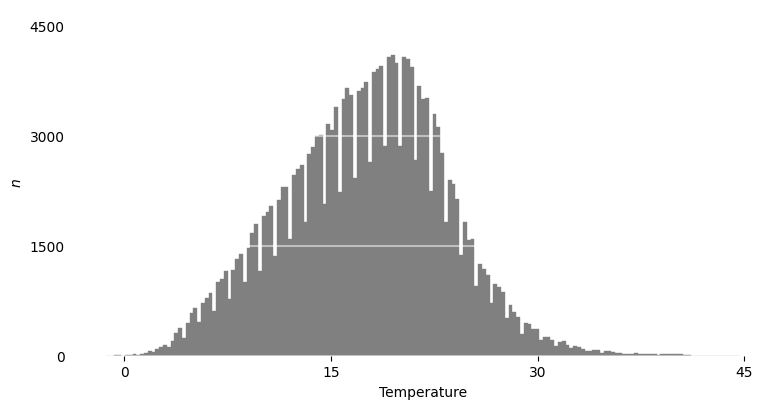

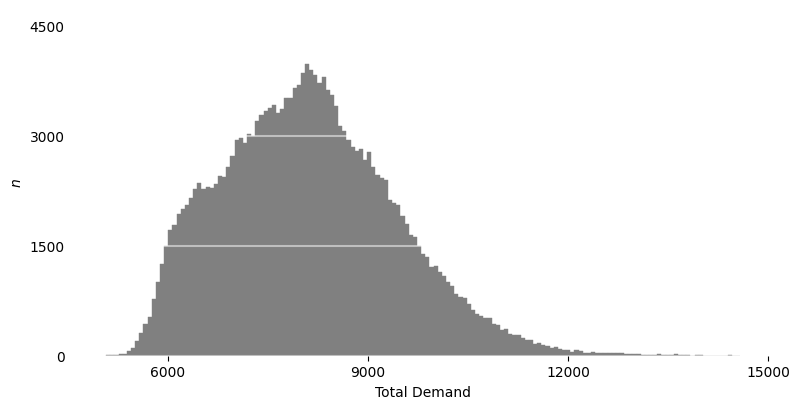

In [11]:
for col in ['Temperature', 'Total Demand']:
    fig, ax = plt.subplots(figsize=(9, 4.5))
    col_label = col.replace(' ', '').upper()
    
    # df.TEMPERATURE.hist(ax = ax)
    sns.histplot(df, x=col_label, color='grey', edgecolor='grey', alpha=1)
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(4))
    ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
    for line in ax.get_yticks():
        ax.axhline(line, 0, max(ax.get_xticks()), color='white', alpha=0.5)
    
    for side in ax.spines:
        ax.spines[side].set_visible(False)
    
    ax.tick_params(axis='y', color='white')
    ax.set_xlabel(col)
    ax.set_ylabel('$n$')
    
    show(fig, [ax], file=f'{col} histogram')


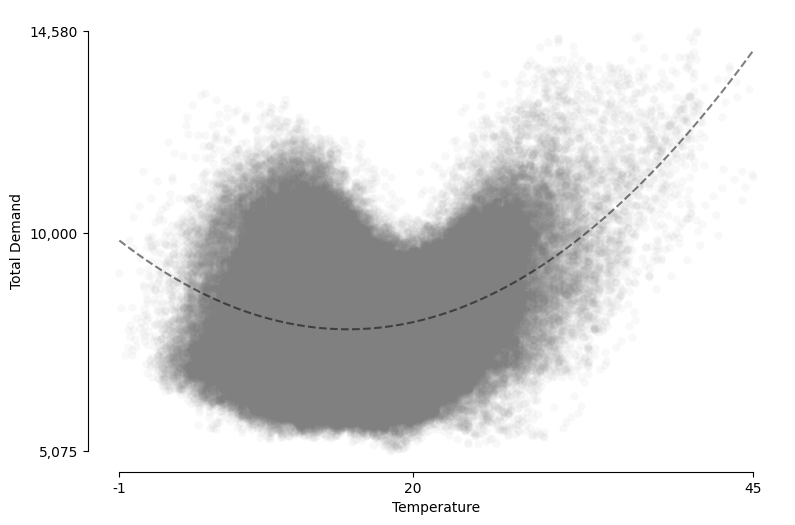

In [12]:
dvt_model = ols("TOTALDEMAND ~ TEMPERATURE + I(TEMPERATURE**2)", df).fit()
lobf_X = np.linspace(min(df.TEMPERATURE), max(df.TEMPERATURE), 1000)
lobf_y =  dvt_model.predict(pd.Series(lobf_X, name='TEMPERATURE'))

fig, ax = plt.subplots(figsize=(9, 6))

sns.scatterplot(
    df, y='TOTALDEMAND', x='TEMPERATURE', ax=ax,
    alpha=0.05, c='grey', lw=0, edgecolor='grey'
)
ax.plot(lobf_X, lobf_y, ls='--', c='black', alpha=.5)

ax.set_xlabel('Temperature')
ax.set_ylabel('Total Demand')

neaten_ticks(ax, 'x', [df.TEMPERATURE.min(), df.TEMPERATURE.max()], [20])
neaten_ticks(ax, 'y', [df.TOTALDEMAND.min(), df.TOTALDEMAND.max()], [1e4])

ax.set_yticklabels([f"{e:,.0f}" for e in ax.get_yticks()])

show(fig, [ax], file=f'Total demand vs. temperature scatterplot', filetype='png')


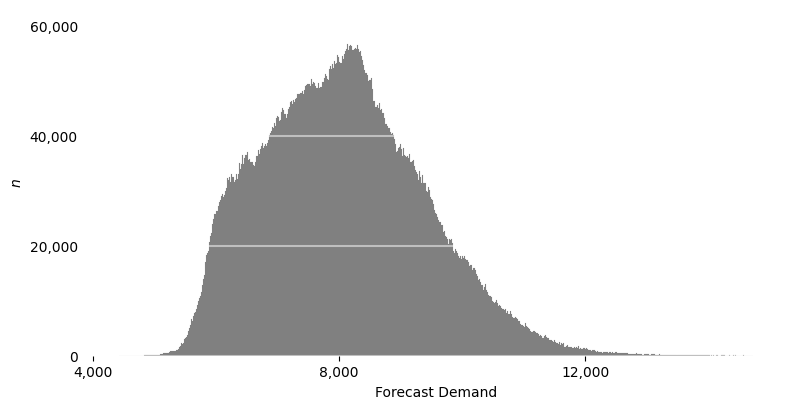

In [13]:
fig, ax = plt.subplots(figsize=(9, 4.5))
col_label = col.replace(' ', '').upper()

sns.histplot(fore, x='FORECASTDEMAND', color='grey', edgecolor='grey', alpha=1)

ax.xaxis.set_major_locator(ticker.MaxNLocator(3))
ax.yaxis.set_major_locator(ticker.MaxNLocator(3))
ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
for line in ax.get_yticks():
    ax.axhline(line, 0, max(ax.get_xticks()), color='white', alpha=0.5)
    
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

for side in ax.spines:
    ax.spines[side].set_visible(False)

ax.tick_params(axis='y', color='white')
ax.set_xlabel('Forecast Demand')
ax.set_ylabel('$n$')

show(fig, [ax], file=f'Forecast demand histogram')


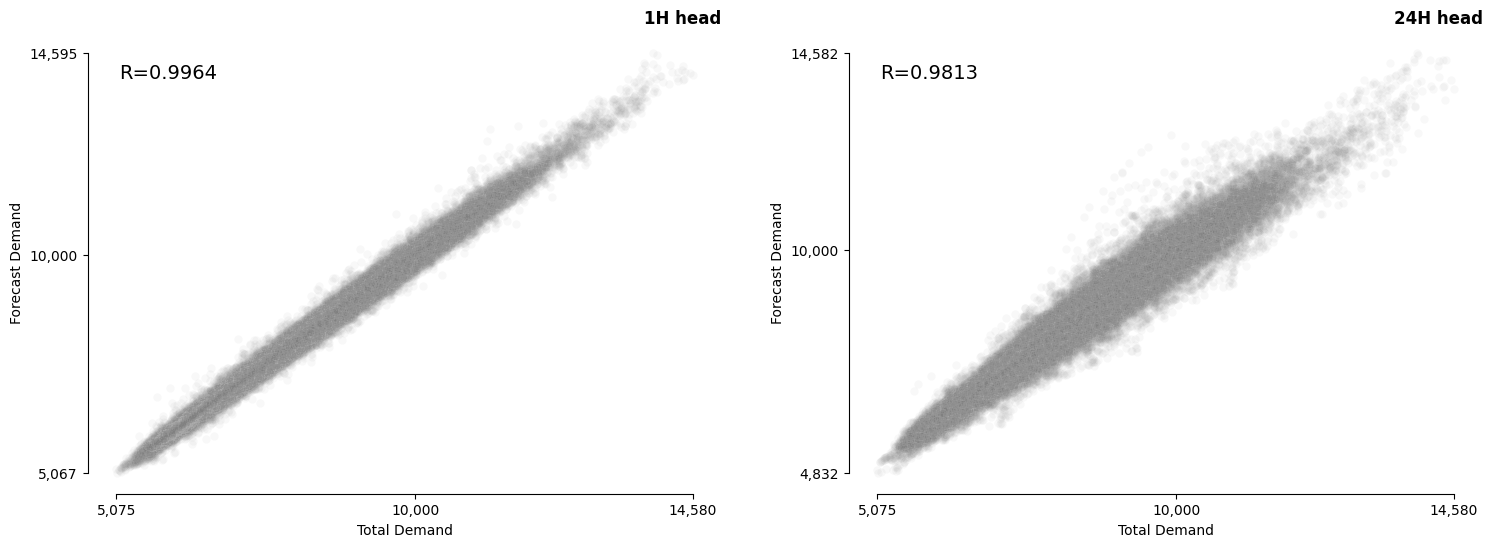

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes = axes.flatten()

hours_ahead = [2, 48]
for i, period in enumerate(hours_ahead):
    ax = axes[i]
    data = pd.merge(df, fore[fore.PERIODID == period][['DATETIME', 'state', 'FORECASTDEMAND']], how='left', on=['DATETIME', 'state'])\
        .dropna().reset_index(drop=True)

    x, y ='TOTALDEMAND', 'FORECASTDEMAND'
    sns.scatterplot(data, x=x, y=y, ax=ax, alpha=0.05, c='grey')
    corr = pearsonr(data[x], data[y]).statistic
    ax.text(0.05, .9, f"R={corr:.04f}", transform=ax.transAxes, fontsize=14)
    
    ax.set_title(f"{period//2}H head", loc='right', fontweight=600)
    ax.set_xlabel('Total Demand')
    ax.set_ylabel('Forecast Demand')

    neaten_ticks(ax, 'x', [data.TOTALDEMAND.min(), data.TOTALDEMAND.max()], [1e4])
    neaten_ticks(ax, 'y', [data.FORECASTDEMAND.min(), data.FORECASTDEMAND.max()], [1e4])

    ax.set_xticklabels([f"{e:,.0f}" for e in ax.get_xticks()])
    ax.set_yticklabels([f"{e:,.0f}" for e in ax.get_yticks()])

show(fig, axes, file=f'Forecast vs. actual for 1- and 24-hours', legend_loc=0, filetype='png')



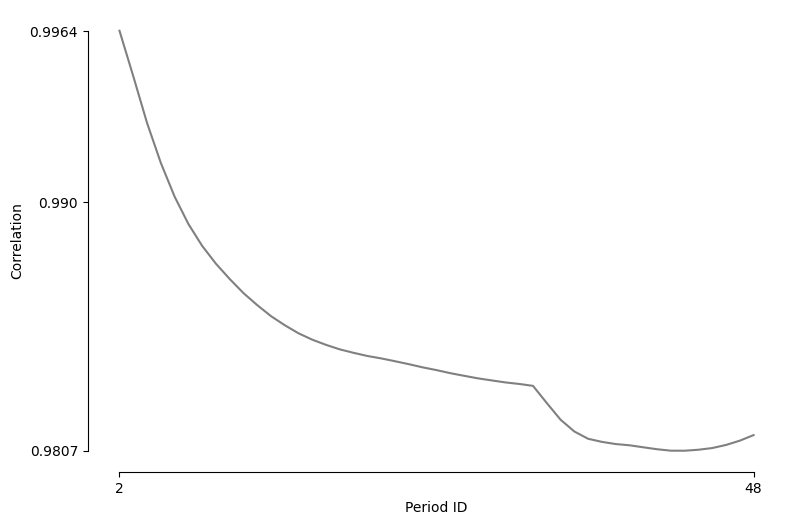

In [15]:
corrs = []
for i in range(min(hours_ahead), max(hours_ahead)+1):
    data = pd.merge(df, fore[fore.PERIODID == i][['DATETIME', 'state', 'FORECASTDEMAND']], how='left', on=['DATETIME', 'state'])\
        .dropna().reset_index(drop=True)
    corr = pearsonr(data[x], data[y]).statistic
    corrs.append({'PERIODID': i, 'correlation': corr})

data = pd.DataFrame(corrs).sort_values('PERIODID')

fig, ax = plt.subplots(figsize=(9, 6))

data.plot(ax=ax, x='PERIODID', c='grey', alpha=1)

neaten_ticks(ax, 'x', [data.PERIODID.min(), data.PERIODID.max()], [])
neaten_ticks(ax, 'y', [data.correlation.min(), data.correlation.max()], [.99], dp=4)
ax.get_legend().remove()
ax.set_xlabel('Period ID')
ax.set_ylabel('Correlation')

show(fig, [ax], file=f'Forecast vs. actual correlation by Period ID', legend_loc=0)


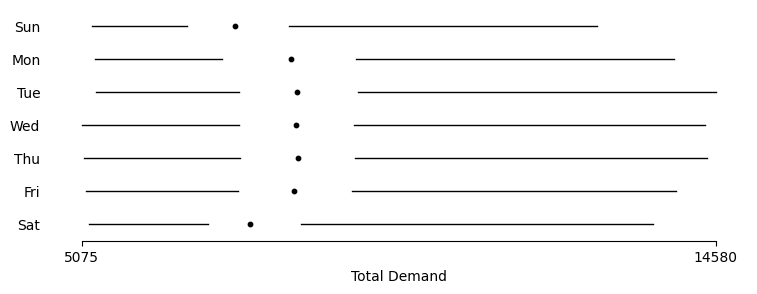

In [16]:
data = df.groupby(['day', 'day_label']).TOTALDEMAND.apply(list).sort_index(ascending=False)
medians = data.apply(np.median)

fig, ax = plt.subplots(figsize=(9, 3))

bplot = ax.boxplot(
    x=data, vert=False, labels = [e[1] for e in data.index], showbox=False,
    medianprops={'linewidth': 0}, whis=5, showcaps=False,
)
ax.scatter(medians, range(1, len(medians.index)+1), s=10, c='black')

ax.set_xlabel('Total Demand')

neaten_ticks(ax, 'x', [
    data.explode().to_frame().min().squeeze(), 
    data.explode().to_frame().max().squeeze()
], [])

ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='major', left=False)

show(fig, [ax], file='Demand by day boxplots')


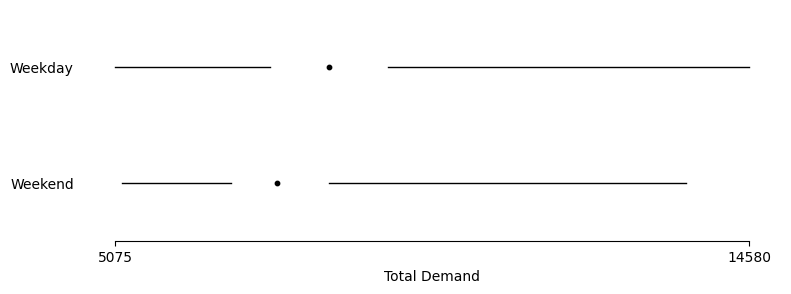

In [17]:
data = df.groupby('is_weekday').TOTALDEMAND.apply(list).sort_index()
medians = data.apply(np.median)

fig, ax = plt.subplots(figsize=(9, 3))

ax.boxplot(
    x=data, vert=False, labels = ['Weekday' if e else 'Weekend' for e in data.index], showbox=False,
    medianprops={'linewidth': 0}, whis=5, showcaps=False
)
ax.scatter(medians, range(1, len(medians.index)+1), s=10, c='black')

ax.set_xlabel('Total Demand')

neaten_ticks(ax, 'x', [
    data.explode().to_frame().min().squeeze(), 
    data.explode().to_frame().max().squeeze()
], [])

ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='major', left=False)

show(fig, [ax], file='Demand by is-weekend boxplots')


In [131]:
fore_piv = fore.pivot(columns='PERIODID', index='DATETIME', values='FORECASTDEMAND').reset_index()
fore_piv.columns = [e if e=='DATETIME' else f"h{e/2:.0f}_ahead" for e in fore_piv.columns]

fore_piv


,DATETIME,h1_ahead,h24_ahead
0,2010-01-01 00:00:00,7789.50,7822.38
1,2010-01-01 00:30:00,7603.17,7715.68
2,2010-01-01 01:00:00,7304.27,7482.56
3,2010-01-01 01:30:00,7046.39,7129.32
4,2010-01-01 02:00:00,6680.15,6800.73
...,...,...,...
196506,2021-03-17 22:00:00,7412.81,7284.49
196507,2021-03-17 22:30:00,7379.27,7240.18
196508,2021-03-17 23:00:00,7316.62,7145.45
196509,2021-03-17 23:30:00,7187.72,7011.96


In [144]:
# mmatrix(pd.merge(df, fore_piv, how='outer', on='DATETIME').sort_values('DATETIME'))

h1_ahead = df.copy()[['DATETIME', 'TOTALDEMAND']].rename(columns={'TOTALDEMAND': 'h1_ahead'})
h1_ahead.DATETIME -= timedelta(minutes=30)
h24_ahead = df.copy()[['DATETIME', 'TOTALDEMAND']].rename(columns={'TOTALDEMAND': 'h1_ahead'})
h24_ahead.DATETIME -= timedelta(days=1)

for ahead in [h1_ahead, h24_ahead]:
    df = pd.merge(df, ahead, how='left', on='DATETIME')

df


,DATETIME,TEMPERATURE,state,TOTALDEMAND,REGIONID,day,day_label,is_weekday,h1_ahead_x,h1_ahead_y
0,2010-01-01 00:00:00,23.1,NSW,8038.00,NSW1,5,Fri,True,7809.31,7574.85
1,2010-01-01 00:30:00,22.9,NSW,7809.31,NSW1,5,Fri,True,7483.69,7343.30
2,2010-01-01 01:00:00,22.6,NSW,7483.69,NSW1,5,Fri,True,7117.23,7099.73
3,2010-01-01 01:30:00,22.5,NSW,7117.23,NSW1,5,Fri,True,6812.03,6779.80
4,2010-01-01 02:00:00,22.5,NSW,6812.03,NSW1,5,Fri,True,6544.33,6497.47
...,...,...,...,...,...,...,...,...,...,...
195968,2021-03-17 22:00:00,19.7,NSW,7419.77,NSW1,3,Wed,True,7417.91,NaN
195969,2021-03-17 22:30:00,19.5,NSW,7417.91,NSW1,3,Wed,True,7287.32,NaN
195970,2021-03-17 23:00:00,19.1,NSW,7287.32,NSW1,3,Wed,True,7172.39,NaN
195971,2021-03-17 23:30:00,18.8,NSW,7172.39,NSW1,3,Wed,True,7094.51,NaN


In [118]:
fore[fore.DATETIME == datetime(2021,3,17,23,30)]

fore[fore.groupby('DATETIME').PERIODID.transform('count') > 2]


,PREDISPATCHSEQNO,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME,state


In [79]:
X_y_df = df.dropna().drop(columns=['DATETIME', 'state', 'REGIONID', 'day', 'day_label']).astype(float)
X_df = X_y_df.dropna().drop(columns=['TOTALDEMAND'])
y_df = X_y_df.dropna().TOTALDEMAND
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

X_y = [X_train, X_test, y_train, y_test] = train_test_split(
    X_scaled, y_df, test_size=0.2, shuffle=False
)
X_y = [tf.convert_to_tensor(d) for d in X_y]
[X_train, X_test, y_train, y_test] = X_y

train_val_I = TimeSeriesSplit(n_splits=10).split(X_train)

for train, val in train_val_I:
    print(train.shape, val.shape)

X_train


(14257,) (14250,)
(28507,) (14250,)
(42757,) (14250,)
(57007,) (14250,)
(71257,) (14250,)
(85507,) (14250,)
(99757,) (14250,)
(114007,) (14250,)
(128257,) (14250,)
(142507,) (14250,)


<tf.Tensor: shape=(156757, 2), dtype=float64, numpy=
array([[ 0.94643429,  0.63250411],
       [ 0.91244494,  0.63250411],
       [ 0.86146092,  0.63250411],
       ...,
       [ 0.232658  , -1.5810174 ],
       [ 0.30063669, -1.5810174 ],
       [ 0.30063669, -1.5810174 ]])>

In [85]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier


In [89]:
main_input = Input(shape=(2,), name="input")
previous_layer = main_input
for i in range(5):
    # previous_layer = BatchNormalization()(previous_layer)
    previous_layer = Dense(32, name=f"linear_{i+1}", activation='linear')(previous_layer)
    previous_layer = Dense(32, name=f"relu_{i+1}", activation='relu')(previous_layer)
main_output = Dense(1, name=f"output")(previous_layer)

model_mlp = Model(inputs=main_input, outputs=main_output, name="MLP")
model_mlp.compile(optimizer=Adam(
    learning_rate=.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    name='Adam',
), loss=MeanSquaredError(), metrics=[MSE, MAPE])
model_mlp.fit(X_train, y_train, epochs=1000, batch_size=2**5, verbose=1, callbacks=[EarlyStopping(monitor='loss', patience=3)])



Epoch 1/1000
4899/4899 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 5779809.0000 - mean_absolute_percentage_error: 17.9343 - mean_squared_error: 5779809.0000
Epoch 2/1000
4899/4899 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 1387178.6250 - mean_absolute_percentage_error: 11.9266 - mean_squared_error: 1387178.6250
Epoch 3/1000
4899/4899 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 1387186.0000 - mean_absolute_percentage_error: 11.9318 - mean_squared_error: 1387186.0000
Epoch 4/1000
4899/4899 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 1383921.5000 - mean_absolute_percentage_error: 11.9388 - mean_squared_error: 1383921.5000
Epoch 5/1000
4899/4899 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 1380461.6250 - mean_absolute_percentage_error: 11.8969 - mean_squared_error: 1380461.6250
Epoch 6/1000
4899/4899 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 1372860.2500 - mean_absolute_percentage_error: 11.8762 - mean_squared_error: 1372860.2500
Epoch 7/1000
4899/4899 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 13814

In [90]:
y_pred = model_mlp.predict(X_test)
print(r2_score(y_test, y_pred))


1225/1225 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
0.09487461718102186


In [91]:
from statsmodels.formula.api import ols

model = ols("TOTALDEMAND ~ TEMPERATURE + I(TEMPERATURE**2) + I(TEMPERATURE**3) + I(TEMPERATURE**4) + is_weekday", X_y_df).fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TOTALDEMAND   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     9211.
Date:                Fri, 22 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:38:11   Log-Likelihood:            -1.6622e+06
No. Observations:              195947   AIC:                         3.324e+06
Df Residuals:                  195941   BIC:                         3.324e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            5162.9692     47.819    107.968      0.000    5069.244    5256.694
TEMPERATURE           815.2832     12.319     66.181      0.000     791.138     839.428
I(TEMPERATURE ** 2)   -82.2840      1.091    -75.426      0.000     -84.422     -80.146
I(TEMPERATURE ** 3)     3.0520      0.039     77.373      0.000       2.975       3.129
I(TEMPERATURE ** 4)    -0.0353      0.000    -71.227      0.000      -0.036      -0.034
is_weekday            718.0934      5.846    122.830      0.000     706.635     729.552
==============================================================================
Omnibus:                     1249.916   Durbin-Watson:                   0.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1146.740
Skew:                           0.150   Prob(JB):                    9.74e-250
Kurtosis:                       2.777   Cond. No.                     4.92e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.92e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
model.evaluate(X_val,  y_val, verbose=2)


4526/4526 - 6s - 1ms/step - accuracy: 0.0000e+00 - loss: 714211.7500 - mse: 714328.1250


[714211.75, 0.0, 714328.125]

In [26]:
y_pred = model.predict(X_val)

r2_score(y_val, y_pred)


4526/4526 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


0.9016066039647717

In [29]:
from tensorflow import keras # for building Neural Networks
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Bidirectional, GRU, RepeatVector, Dense, TimeDistributed # for creating layers inside the Neural Network


In [55]:
start = datetime.now()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

mlp = MLPRegressor(
    hidden_layer_sizes=(10, 10, 10, 10, 10), solver='adam', 
    max_iter=1000, random_state=1
)
mlp.fit(X=X_train_scaled, y=y_train)
y_pred = mlp.predict(X_val_scaled)

print('Train time:', datetime.now() - start)
print('R-squared:', r2_score(y_val, y_pred))

mlp


Train time: 0:00:19.339882
R-squared: 0.9947232481914644


MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10, 10), max_iter=1000,
             random_state=1)

**MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=1000, random_state=1)**  
Train time: 0:02:50.626288  
R-squared: 0.903996701869163  

**MLPRegressor(hidden_layer_sizes=(30, 30, 30), max_iter=1000, random_state=1)**  
Train time: 0:07:13.764777  
R-squared: 0.9029300360828791  

  
**MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=1)**  
Train time: 0:04:49.145756  
R-squared: 0.904020785674071  

**MLPRegressor(hidden_layer_sizes=(100), max_iter=1000, random_state=1)**  
Train time: 0:30:34.488262  
R-squared: 0.9042026519524867  
  
**MLPRegressor(hidden_layer_sizes=(1,), max_iter=1000, random_state=1)**  
Train time: 0:15:16.664206  
R-squared: -1.2258165361865667  

**MLPRegressor(hidden_layer_sizes=(5, 5, 5), max_iter=1000, random_state=1)**  
Train time: 0:07:20.061461  
R-squared: 0.9029303895811518  
  
**MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10, 10), max_iter=1000, random_state=1)**  
Train time: 0:00:54.204514  
R-squared: 0.903889951968013  

**MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10, 10, 10, 10, 10, 10, 10), max_iter=1000, random_state=1)**  
Train time: 0:02:17.239752  
R-squared: 0.8997796694909751  

**MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10, 10), max_iter=1000, random_state=1, solver='sgd')**  
Train time: 0:10:37.488748  
R-squared: -2.325212494791451e-05  




In [121]:
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from urllib.parse import quote_plus


In [132]:
uri = "mongodb+srv://<user>:<password>@project-data.cfluj8d.mongodb.net/?retryWrites=true&w=majority&appName=project-data"\
    .replace('<user>', quote_plus(user)).replace('<password>', quote_plus(psw))

# Create a new client and connect to the server
client = MongoClient(uri, server_api=ServerApi('1'))

# Send a ping to confirm a successful connection
client.admin.command('ping')
print("Pinged your deployment. You successfully connected to MongoDB!")



Pinged your deployment. You successfully connected to MongoDB!


In [207]:
print(client.list_database_names())


['data', 'admin']
['forecast_demand', 'total_demand', 'temperature']


In [208]:
# client['data']['temperature'].insert_many(temp.to_dict(orient='records'))
# client['data']['total_demand'].insert_many(dem.to_dict(orient='records'))
# client['data']['forecast_demand'].insert_many(fore.to_dict(orient='records'))


In [210]:
for col in client['data'].list_collection_names():
    print(f"{col}: {client['data'][col].count_documents({}):,} records")
    

forecast_demand: 23,192,795 records
total_demand: 786,051 records
temperature: 778,177 records
